In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# set traditional Chinese display
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

In [3]:
# Load the datasets
# convert_shot.csv: The result after running transform.py
data = pd.read_csv('../dataset/doubles 2/doubles/convert_shot.csv', encoding='utf-8')
rally_data = pd.read_csv('../dataset/doubles 2/doubles/rally.csv', encoding='utf-8')
set_data = pd.read_csv('../dataset/doubles 2/doubles/set.csv', encoding='utf-8')

# Filter players
players_filtered = data[~((data['rally_id'] >= 73) & (data['rally_id'] <= 143))]

# Get the maximum shot number for each rally
max_shots_per_rally = players_filtered.groupby('rally_id')['shot_num'].max().reset_index()
max_shots_per_rally.columns = ['rally_id', 'max_shot_num']

# Merge the max_shots_per_rally back to the players_filtered
players_filtered = players_filtered.merge(max_shots_per_rally, on='rally_id', how='left')

# Merge rally_data with set_data to include set_win information
rally_set_merged = rally_data.merge(set_data[['set_id', 'set_win']], on='set_id', how='left')

# Initialize the list to collect rows
rows_list_win = []
rows_list_lose = []

# Initialize previous shot variable
prev = ""

# Iterate over the filtered DataFrame rows
for idx, row in players_filtered.iterrows():
    if row['shot_num'] == 1:
        continue

    # Check ball type
    if row['ball_type'] in ['擋小球', '勾球', '放小球', '小平球']:
        row['ball_type'] = '網前小球'
    elif row['ball_type'] == '防守回挑':
        row['ball_type'] = '挑球'
    elif row['ball_type'] in ['防守回抽', '後場抽平球']:
        row['ball_type'] = '平球'
    elif row['ball_type'] == '過度切球':
        row['ball_type'] = '切球'
    elif row['ball_type'] in ['推球', '撲球']:
        row['ball_type'] = '推撲球'

    if row['player'] != 14 and row['player'] != 33:
        prev = row["ball_type"]
        continue

    newrow = {
        "shot_id": row["shot_id"],
        "up_court": 0,
        "score": 0,
        "hit_player_x": None,
        "hit_player_y": None,
        "partner_x": None,
        "partner_y": None,
        "ball_type": row["ball_type"],
        "opponent_ball_type": None,
    }
    # print(row)
    if not ((row['hit_y'] < 67) ^ (row['player_A_y'] < 67)):
        if row['player'] == 14:
            newrow["hit_player_x"] = row['player_A_x']
            newrow["hit_player_y"] = row['player_A_y']
            newrow["partner_x"] = row['player_B_x']
            newrow["partner_y"] = row['player_B_y']
        else:
            newrow["hit_player_x"] = row['player_B_x']
            newrow["hit_player_y"] = row['player_B_y']
            newrow["partner_x"] = row['player_A_x']
            newrow["partner_y"] = row['player_A_y']
    else:
        if row['player'] == 14:
            newrow["hit_player_x"] = row['player_C_x']
            newrow["hit_player_y"] = row['player_C_y']
            newrow["partner_x"] = row['player_D_x']
            newrow["partner_y"] = row['player_D_y']
        else:
            newrow["hit_player_x"] = row['player_D_x']
            newrow["hit_player_y"] = row['player_D_y']
            newrow["partner_x"] = row['player_C_x']
            newrow["partner_y"] = row['player_C_y']

    if newrow["hit_player_y"] > 67:
        newrow["up_court"] = 1
        newrow["hit_player_x"] = 61 - newrow["hit_player_x"]
        newrow["hit_player_y"] = 134 - newrow["hit_player_y"]
        newrow["partner_x"] = 61 - newrow["partner_x"]
        newrow["partner_y"] = 134 - newrow["partner_y"]

    newrow['opponent_ball_type'] = prev

    # Ensure only valid ball types are added
    newrow["ball_type"] = row["ball_type"]

    # Filter out the first match (lose)
    if row['rally_id'] <= 1479 and row['rally_id'] >= 1414:
        # Check if the current shot is one of the last two shots in the rally
        if row['shot_num'] >= row['max_shot_num'] - 1:
            rally_info = rally_set_merged[rally_set_merged['rally_id'] == row['rally_id']].iloc[0]
            set_win = rally_info['set_win']
            score_team = rally_info['score_team']
                
            if set_win == 1:
                if score_team == 0:
                    newrow["score"] = -1
                    rows_list_lose.append(newrow)
                else:
                    newrow["score"] = 1
                    rows_list_win.append(newrow)
            else:
                if score_team == 0:
                    newrow["score"] = 1
                    rows_list_win.append(newrow)
                else:
                    newrow["score"] = -1
                    rows_list_lose.append(newrow)
    else:
        # Check if the current shot is one of the last two shots in the rally
        if row['shot_num'] >= row['max_shot_num'] - 1:
            rally_info = rally_set_merged[rally_set_merged['rally_id'] == row['rally_id']].iloc[0]
            set_win = rally_info['set_win']
            score_team = rally_info['score_team']

            if set_win == 1:
                if score_team == 0:
                    newrow["score"] = -1
                    rows_list_lose.append(newrow)
                else:
                    newrow["score"] = 1
                    rows_list_win.append(newrow)
            else:
                if score_team == 0:
                    newrow["score"] = 1
                    rows_list_win.append(newrow)
                else:
                    newrow["score"] = -1
                    rows_list_lose.append(newrow)
    # print(newrow)

# Create a new DataFrame from the list of rows
win_df = pd.DataFrame(rows_list_win)
lose_df = pd.DataFrame(rows_list_lose)

# Define the desired column order
column_order = [
    "shot_id", "up_court", "hit_player_x", "hit_player_y", "partner_x", "partner_y",
    "opponent_ball_type", "ball_type", "score", "last_shot"
]

# Reorder the columns
win_df = win_df[column_order]
lose_df = lose_df[column_order]
print("size of win_df: ", win_df.shape[0])
print("size of lose_df: ", lose_df.shape[0])

win_df.to_csv('../output/Week9_doubles/processed_shot_win.csv', index=False, encoding='utf-8')
lose_df.to_csv('../output/Week9_doubles/processed_shot_lose.csv', index=False, encoding='utf-8')

size of win_df:  236
size of lose_df:  279


In [8]:
# Load the dataset from CSV file
win_df = win_df.sample(n=200, random_state=1)
lose_df = lose_df.sample(n=200, random_state=1)

# Open a file to write the output in XML format
output_file_path = '../output/Week9_doubles/others.txt'

with open(output_file_path, 'w') as f:
    # Write the header
    f.write('<data>\n')
    f.write('<meta>\n')
    f.write('<attributes>\n')

    # Write attributes - Adjust this part to match your attributes
    f.write('<attribute><type>Numerical</type><name>hit_player_x</name></attribute>\n')
    f.write('<attribute><type>Numerical</type><name>hit_player_y</name></attribute>\n')
    f.write('<attribute><type>Numerical</type><name>partner_x</name></attribute>\n')
    f.write('<attribute><type>Numerical</type><name>partner_y</name></attribute>\n')
    f.write('<attribute><type>Categorical</type><name>Categorical_1</name></attribute>\n')
    f.write('<attribute><type>Categorical</type><name>Categorical_2</name></attribute>\n')
    f.write('</attributes>\n')
    f.write('<hierarchy>\n')

    # Example hierarchy - Adjust as needed based on actual categorical values
    f.write('<Categorical_1 name="opponent_ball_type">\n')
    f.write('<![CDATA[<殺球></殺球><挑球></挑球><網前小球></網前小球><推撲球></推撲球><長球></長球><平球></平球><切球></切球>]]>\n')
    f.write('</Categorical_1>\n')
    f.write('<Categorical_2 name="ball_type">\n')
    f.write('<![CDATA[<殺球></殺球><挑球></挑球><網前小球></網前小球><推撲球></推撲球><長球></長球><平球></平球><切球></切球>]]>\n')
    f.write('</Categorical_2>\n')
    f.write('</hierarchy>\n')
    f.write('</meta>\n')
    f.write('<class>T</class>\n')
    f.write('<dataset>\n')

    # Write the dataset
    for index, row in win_df.iterrows():
        line = str(row['hit_player_x'])+'\t'+str(row['hit_player_y']) +'\t'+str(row['partner_x'])+'\t'+str(row['partner_y']) +'\t'+str(row['opponent_ball_type'])+'\t'+str(row['ball_type']) + '\n'
        f.write(line)
        
    for index, row in lose_df.iterrows():
        line = str(row['hit_player_x'])+'\t'+str(row['hit_player_y']) +'\t'+str(row['partner_x'])+'\t'+str(row['partner_y']) +'\t'+str(row['opponent_ball_type'])+'\t'+str(row['ball_type']) + '\n'
        f.write(line)

    # Close the dataset tag
    f.write('</dataset>\n')
    f.write('</data>\n')

print(f"Data has been successfully written to {output_file_path}")


Data has been successfully written to ../output/Week9_doubles/others.txt


In [ ]:
# Run the mixed-type data clustering script on Linux
# preprocess: 
# 1. download required packages
# 2. modify the file path in Main.java
# 3. compile the Java code in terminal with: "javac -cp "libs/*:bin" -d bin $(find src -name '*.java')"
# 4. run the Java code in terminal with: "java -cp "libs/*:bin" Main"

In [37]:
# Load the clustering result from mixted-type data clustering
total_df = win_df.append(lose_df)
total_df = total_df.reset_index(drop=True)

data = pd.read_csv('../output/Week9_doubles/Final Result.csv', encoding='utf-8')
total_df['cluster'] = data['clusterid']
    
# plot the clustering result
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# data_indices = data.index
n = data['clusterid'].max() + 1
for cluster in range(0, n):
    plt.figure(figsize=(9.15, 10.05))

    cluster_data = data[data['clusterid'] == cluster]
    if len(cluster_data) > 60:
        sample_cluster_data = cluster_data.sample(n=60, random_state=1)
    else:
        sample_cluster_data = cluster_data

    plt.scatter(sample_cluster_data['hit_player_x'], sample_cluster_data['hit_player_y'], color='r', label=f'Cluster {cluster} - Hit player')
    plt.plot([sample_cluster_data['hit_player_x'], sample_cluster_data['partner_x']], [sample_cluster_data['hit_player_y'], 
        sample_cluster_data['partner_y']], color='y', label=f'Cluster {cluster} - Partner line') 
    plt.scatter(sample_cluster_data['partner_x'], sample_cluster_data['partner_y'], color='b', label=f'Cluster {cluster} - Partner')
    plt.plot([sample_cluster_data['hit_player_x'].mean(), sample_cluster_data['partner_x'].mean()], [sample_cluster_data['hit_player_y'].mean(), 
        sample_cluster_data['partner_y'].mean()], color='g', label=f'Cluster {cluster} - Mean line', linewidth=5)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 61) 
    plt.ylim(0, 67) 
    plt.savefig(f'../output/Week9_doubles/cluster_{cluster}_positions.jpg')
    plt.close()


In [38]:
total_df.to_csv('../output/Week9_doubles/clustered_data.csv', index=False, encoding='utf-8')

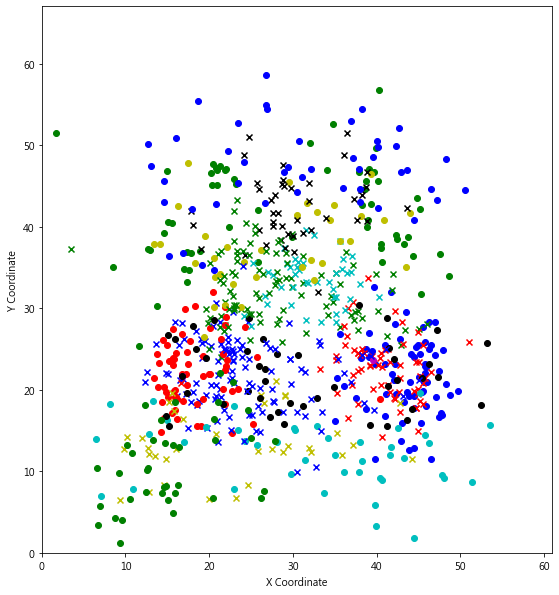

In [39]:
# plot all clustering results in one figure
plt.figure(figsize=(9.15, 10.05))
for cluster in range(n):
    cluster_data = data[data['clusterid'] == cluster]
    plt.scatter(cluster_data['hit_player_x'], cluster_data['hit_player_y'], 
        color=colors[cluster % len(colors)], label=f'Cluster {cluster} - Hit player')
    plt.scatter(cluster_data['partner_x'], cluster_data['partner_y'], 
        color=colors[cluster % len(colors)], marker='x', label=f'Cluster {cluster} - Partner')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 61) 
plt.ylim(0, 67)
# plt.legend()
plt.savefig(f'../output/Week9_doubles/clusters_positions.jpg')
plt.show()

In [40]:
# Define the ball types
ball_types = ["挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]

# Transform one-hot encoding to ball type strings for the opponent's shots
for cluster in range(n):
    clustered_data = total_df[(total_df['cluster'] == cluster)]
    win_ratio = clustered_data['score'][clustered_data['score']==1].count()/clustered_data['shot_id'].count()
    lose_ratio = clustered_data['score'][clustered_data['score']==-1].count()/clustered_data['shot_id'].count()
    print(f"Cluster {cluster} has a winning rate of {win_ratio} and a losing rate of {lose_ratio}")
    
    # Calculate winning rate and losing rate
    if abs(win_ratio - lose_ratio) > 0.1:
        data_type = ['win', 'lose']
        for n, data in enumerate([win_df, lose_df]):
            data = data[data['shot_id'].isin(clustered_data['shot_id'])]
            matrix = pd.crosstab(data['opponent_ball_type'], data['ball_type'], dropna=False)
            matrix = matrix.reindex(index=ball_types, columns=ball_types, fill_value=0)
            
            # Calculate the percentage matrix
            matrix_percentage = matrix / matrix.values.sum() * 100

            plt.figure(figsize=(10, 8))
            sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=ball_types, yticklabels=ball_types)
            plt.xlabel("Our hit ball type")
            plt.ylabel("Opponent's hit ball type")
            plt.yticks(rotation=45)
            plt.title(f'Confusion Matrix (Percentage) for Cluster {cluster} - {data_type[n]}')
            plt.savefig(f'../output/Week9_doubles/cluster_{cluster}_confusion_matrix_percentage_{data_type[n]}.jpg')
            plt.close()
    


Cluster 0 has a winning rate of 0.4782608695652174 and a losing rate of 0.5217391304347826
Cluster 1 has a winning rate of 0.5084745762711864 and a losing rate of 0.4915254237288136
Cluster 2 has a winning rate of 0.5238095238095238 and a losing rate of 0.47619047619047616
Cluster 3 has a winning rate of 0.5116279069767442 and a losing rate of 0.4883720930232558
Cluster 4 has a winning rate of 0.0 and a losing rate of 1.0


c:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Cluster 5 has a winning rate of 0.5142857142857142 and a losing rate of 0.4857142857142857
Cluster 6 has a winning rate of 0.36363636363636365 and a losing rate of 0.6363636363636364
Cluster 7 has a winning rate of 0.5652173913043478 and a losing rate of 0.43478260869565216
Cluster 8 has a winning rate of 0.5384615384615384 and a losing rate of 0.46153846153846156
Cluster 9 has a winning rate of 1.0 and a losing rate of 0.0


c:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


In [45]:
win = total_df[total_df['score'] == 1]
lose = total_df[total_df['score'] == -1]

print("win")
print(win['cluster'].value_counts())

print("lose")
print(lose['cluster'].value_counts())

win
2    33
0    33
1    30
7    26
3    22
8    21
5    18
6    16
9     1
Name: cluster, dtype: int64
lose
0    36
2    30
1    29
6    28
3    21
7    20
8    18
5    17
4     1
Name: cluster, dtype: int64
